# Store Sales Forecasting 

## Definitions and imports

In [50]:
from unittest import findTestCases
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../learntools/learntools/time_series")
from utils import *
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

In [4]:
class Cleaning_Data():
    def replace_nans(pd_list):
        for data_set in pd_list:
            print("Cleaning data set:",data_set.name)

            #print(data_set.isnull().sum())
            # only oil has any nans to worry about

            if data_set.name=="oil":
                data_set["dcoilwtico"] = data_set["dcoilwtico"].interpolate('linear')

In [5]:
class Boostedhybrid:
    def __init__(self,model1,model2):
        self.model1= model1
        self.model2= model2
        self.y_columns = None

    def fit(self,X_1,X_2,y):
        self.model1.fit(X_1,y)
        y_fit=pd.DataFrame(self.model1.predict(X_1),index=X_1.index,columns=y.columns)
        y_resid = y-y_fit
        y_resid = y_resid.stack().squeeze()
        
        self.model2.fit(X_2,y_resid)

        self.y_columns=y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid
    def predict(self,X_1,X_2):
        y_pred = pd.DataFrame(self.model1.predict(X_1),index=X_1.index,columns=self.y_columns)
        y_pred = y_pred.stack().squeeze()
        y_pred +=self.model2.predict(X_2)
        return y_pred.unstack()

## DataFrames

In [166]:
train_set = pd.read_csv("train.csv")
train_set.name = "train"
holiday_events = pd.read_csv("holidays_events.csv")
holiday_events.name = "holiday_events"
oil = pd.read_csv("oil.csv")
oil.name="oil"
stores = pd.read_csv("stores.csv")
stores.name="stores"

store_sales = pd.read_csv('train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32'
    },
    parse_dates=['date'],
    infer_datetime_format=True)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

holidays_events = pd.read_csv("holidays_events.csv",
                              dtype={
          'type': 'category',
          'locale': 'category',
          'locale_name': 'category',
          'description': 'category',
          'transferred': 'bool',
        },
      parse_dates=['date'],
      infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D') 



#declaring class
clean = Cleaning_Data

pd_list = [train_set,oil,stores]

clean.replace_nans(pd_list)

    
# transform date indices
oil["date"] = pd.to_datetime(oil["date"])
train_set["date"] = pd.to_datetime(train_set["date"])
holiday_events["date"] = pd.to_datetime(holiday_events["date"])

Cleaning data set: train
Cleaning data set: oil
Cleaning data set: stores


## Examine the data

Display the oil prices in the time range

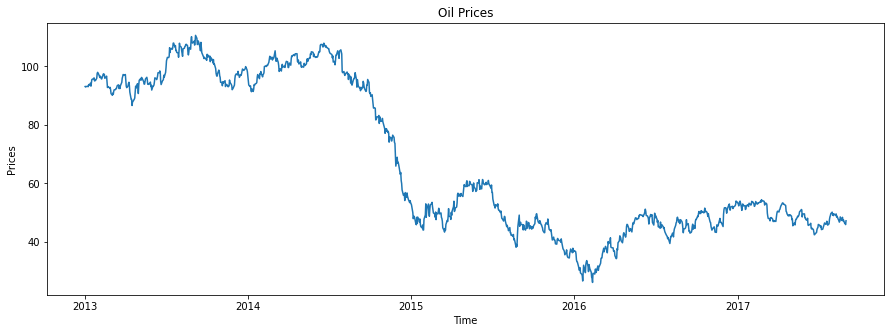

In [18]:
plt.plot(oil["date"],oil["dcoilwtico"])
plt.ylabel("Prices")
plt.xlabel("Time")
plt.title("Oil Prices")
plt.rcParams['figure.figsize'] = [15, 5]

Display Family Sale Means in decreasing order

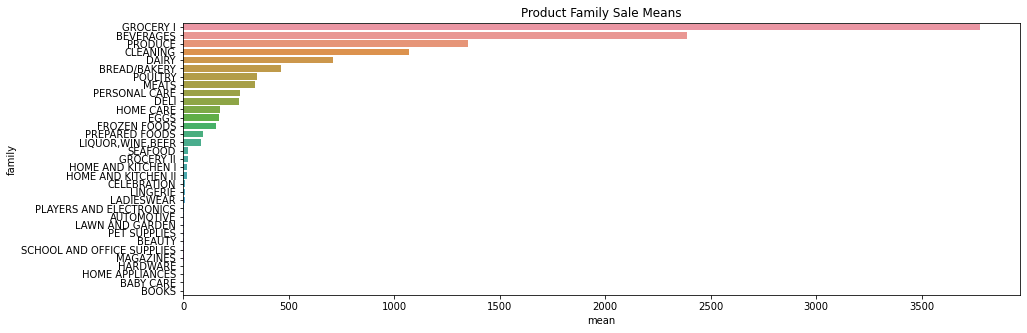

In [21]:
families = list(train_set["family"].unique())

sns.barplot( data= train_set.groupby('family')["sales"].agg(['mean']).sort_values(by = 'mean', ascending = False).reset_index(),x = 'mean',y= 'family')
plt.title("Product Family Sale Means")
plt.rcParams['figure.figsize'] = [15, 5]


Show the top 15 families sales for each store over time interval. We show each individual store to see if there is any obvious variability in patterns, but generally we will be looking at the store average.

In [23]:
cols_to_show = train_set.groupby('family')['sales'].agg(['mean']).sort_values(by = 'mean',ascending=False).reset_index().iloc[0:15,0].to_list()
store_numbers = list(train_set["store_nbr"].unique())

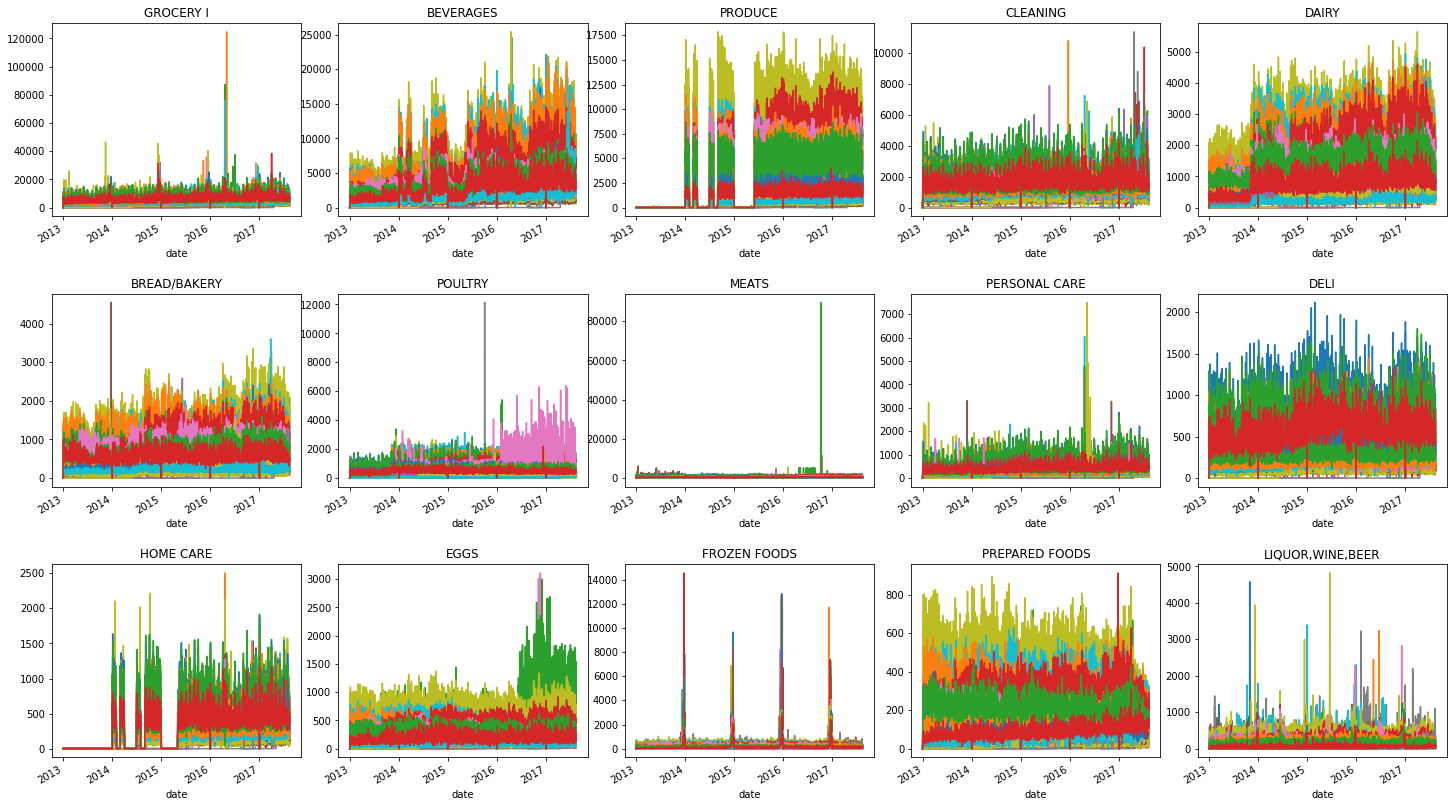

In [29]:
fig, ax = plt.subplots(3,5,figsize=(25,15))
for i,family in enumerate(cols_to_show):
    for store_number in store_numbers:
        #if store_number == 10:
            train_set[(train_set.store_nbr == store_number)& (train_set.family==family)].plot(ax=ax[i//5,i%5],x='date',y='sales',label=None)
            ax[i//5,i%5].set_title(family)
            ax[i//5,i%5].legend().set_visible(False)
    plt.subplots_adjust(wspace=0.15,hspace=0.4)

Look at average total sales as a function of oil price. There appears to be a correlation so we will include oil prices as a feature later.

In [32]:
temp_df = pd.merge(left = train_set, right = oil, on = 'date')
temp_df = pd.merge(left = temp_df, right = temp_df.groupby('date')['sales'].agg(['mean']), on ='date')

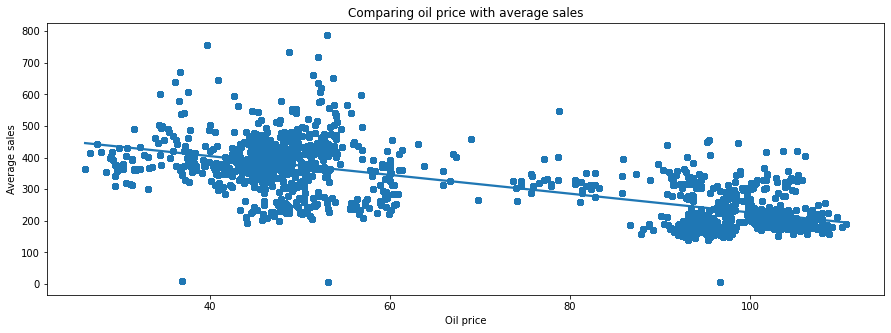

In [33]:
sns.regplot(data = temp_df,x='dcoilwtico',y='mean')
plt.title(f'Comparing oil price with average sales')
plt.xlabel('Oil price')
plt.ylabel('Average sales')
plt.rcParams['figure.figsize'] = [15, 5]

Show average sales for year 2016 with holidays highlighted to see how sales depend on holidays.

In [34]:
temp_df1 = pd.merge(left = train_set, right = holiday_events, on = 'date')

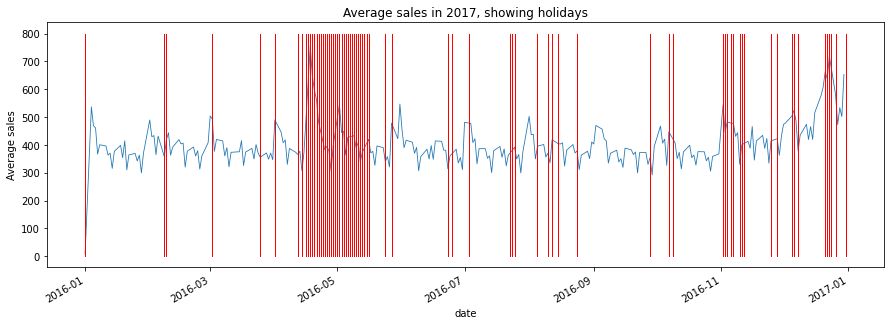

In [41]:
temp_df[temp_df['date'].dt.year == 2016].plot(x='date', y='mean',  lw=0.8, legend=None)
plt.vlines(x=temp_df1[temp_df1['date'].dt.year == 2016].date, color='red', ymin=0,ymax=800, lw=0.9, alpha=0.7)
plt.title('Average sales in 2016, showing holidays')
plt.ylabel('Average sales')
plt.rcParams['figure.figsize'] = [15, 5]

Look at the periodogram for any seasonality of the average sales in year 2016.

In [52]:
average_sales_2016 = (store_sales.groupby('date').mean().squeeze().loc['2016'])
holidays = (holidays_events.query("locale in ['National', 'Regional']")
            .loc['2016',['description']]
            .assign(description=lambda x: x.description.cat.remove_unused_categories()))

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_46242/792669265.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(average_sales_2016);


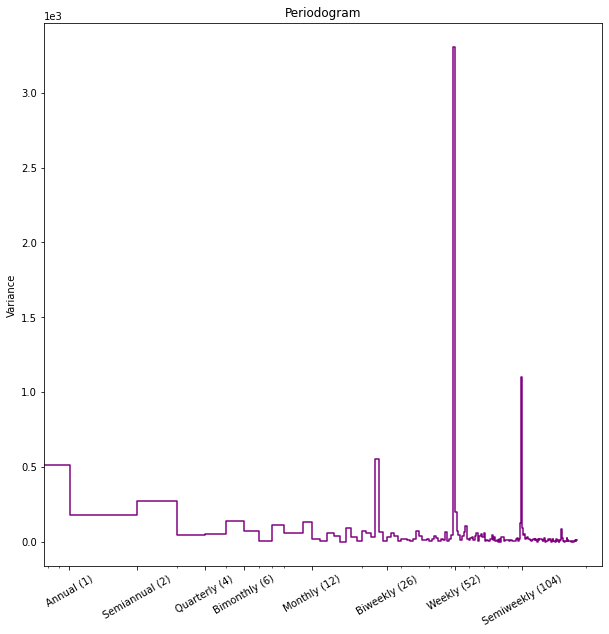

In [54]:
plot_periodogram(average_sales_2016);

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_46242/2668000423.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram_grid(ts_list,family_list);


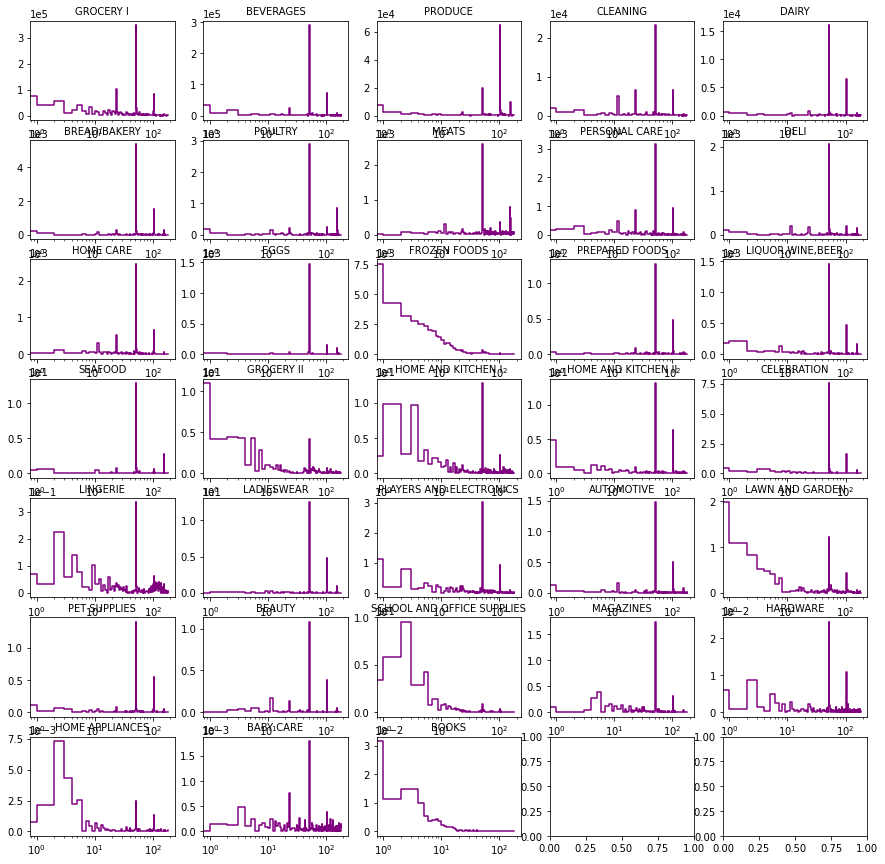

In [51]:
family_list = train_set.groupby('family')['sales'].agg(['mean']).sort_values(by = 'mean',ascending=False).reset_index().iloc[:,0].to_list()
    
ts_list =[]
for i in range(len(family_list)):
    ts_list.append(train_set[(train_set.family==family_list[i])].groupby('date')['sales'].mean().squeeze().loc['2016'])
    #print(train_set[(train_set.family==family_list[i])].groupby('date').mean().squeeze().loc['2017'].info())
plot_periodogram_grid(ts_list,family_list);

## Average Sales

In the previous section we noticed there was clearly weekly and likely monthly seasonality, as well with spikes in the data according to certain holidays. We will begin playing with the data features and seasonality with average sales, rather than each family individually, as a simpler starting point.

### 2016

Here we create seasonal features as well as one hot encoded holiday features as input for a linear model of 2016 average sales.

In [78]:
y = average_sales_2016.copy()

In [79]:
fourier = CalendarFourier("M",4)
dp = DeterministicProcess(index = y.index,
                          constant=True,
                          order=1,
                          seasonal=True,
                          additional_terms=[fourier],
                          drop=True,
                         )
X = dp.in_sample()

In [80]:
ohe = OneHotEncoder(sparse=False)
X_holidays = pd.DataFrame(
       ohe.fit_transform(holidays),
       index=holidays.index,
       columns=holidays.description.unique(),
)

X2 = X.join(X_holidays, on='date').fillna(0.0)
X2 = X2[~X2.index.duplicated(keep='first')]

Create statistical features; rolling averages for oil, sales, and rolling standard deviation for sales

In [81]:
#y = pd.DataFrame(y,index=y.index,columns=['sales'])


median_7 = y.rolling(7).median()
median_7.name = "median_7"
std_7 = y.rolling(7).std()
std_7.name="std_7"

oil = pd.read_csv("oil.csv",parse_dates=['date'])
oil = oil.set_index('date').to_period('D')

oil_median_7 = oil.rolling(7).median()
oil_median_7.name="oil"
X2 = X2.join(median_7, on='date').fillna(0.0)
X2 = X2.join(std_7,on='date').fillna(0.0)
X2 = X2.join(oil_median_7,on='date').fillna(0.0)

In [82]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

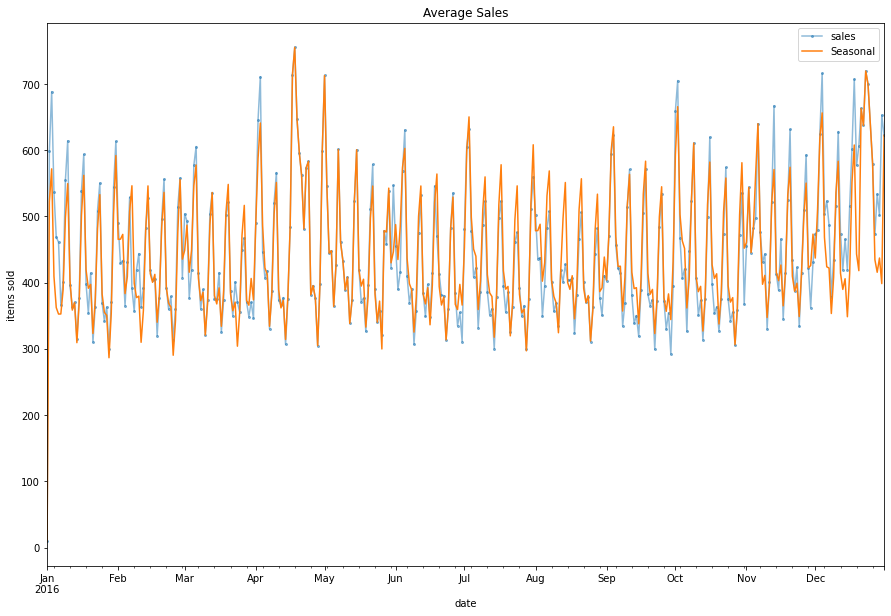

In [83]:
ax = y.plot( alpha=0.5, title="Average Sales", ylabel="items sold",marker="o",markersize=2)
ax = y_pred.plot(ax=ax, label="Seasonal")
plt.rcParams['figure.figsize'] = [15, 10]
ax.legend();

Examine the residuales to better understand the deseasonalized average sales.

In [98]:
y_deseason = y - model.predict(X2)
y_deseason.name = 'sales_deseasoned'

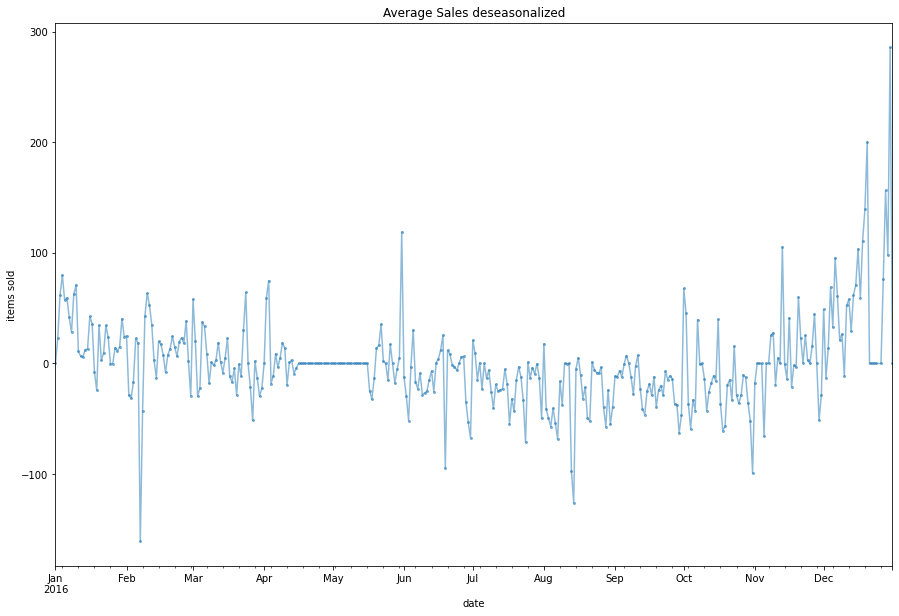

In [70]:
ax = y_deseason.plot( alpha=0.5, title="Average Sales deseasonalized", ylabel="items sold",marker="o",markersize=2)
plt.rcParams['figure.figsize'] = [15, 10]

Plotting the correlations of deseasonalized lags using functions from kaggle's learntools.

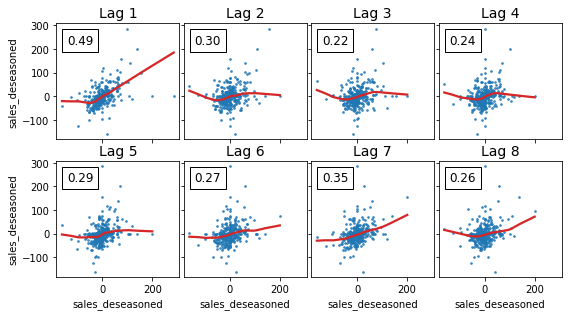

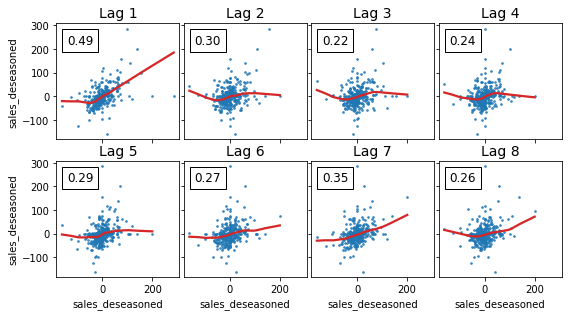

In [73]:
plot_lags(y_deseason,lags=8,nrows=2)

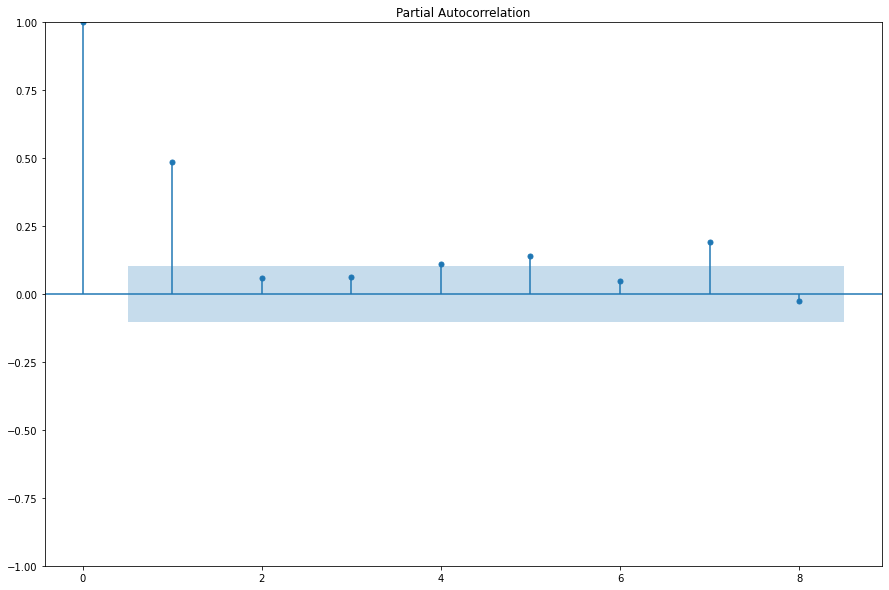

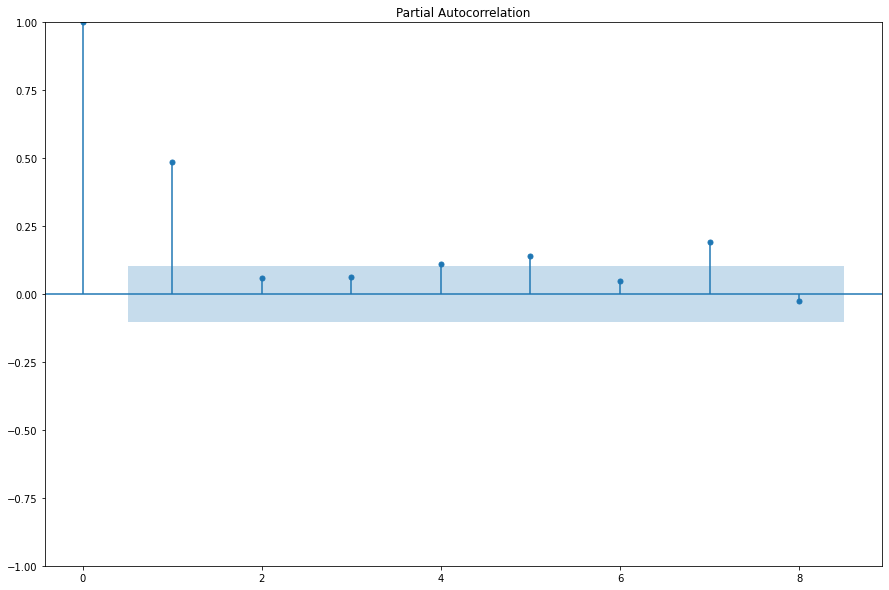

In [72]:
plot_pacf(y_deseason,lags=8)#plot_lags(x=y_deseason.loc[average_sales > 1], y=y_deseason.loc[average_sales > 1], lags=3, leads=3, nrows=1)

In [99]:
X_lags = make_lags(y_deseason,lags=7).dropna(0.0)
y_deseason, X_lags = y_deseason.align(X_lags,join='inner',axis=0)

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_46242/1172302937.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  X_lags = make_lags(y_deseason,lags=7).dropna(0.0)


We create 7 lag features to fit the residual of the average sales with a linear model, and xgb.

In [102]:
model = LinearRegression().fit(X_lags, y_deseason)
y_des_pred = pd.Series(
    model.predict(X_lags),
    index=X_lags.index,
    name='Fitted',
)

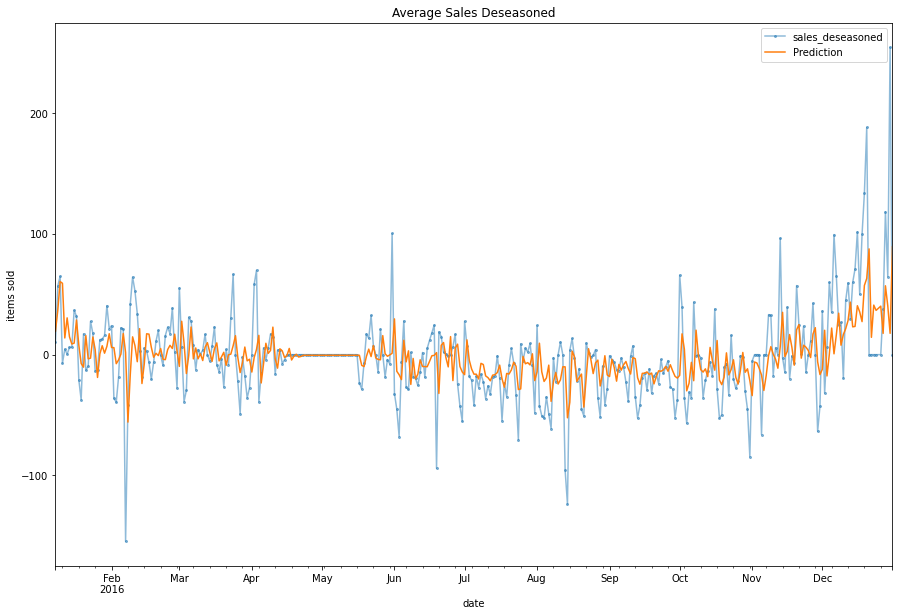

In [105]:
ax = y_deseason.plot( alpha=0.5, title="Average Sales Deseasoned", ylabel="items sold",marker="o",markersize=2)
ax = y_des_pred.plot(ax=ax, label="Prediction")
plt.rcParams['figure.figsize'] = [15, 10]
ax.legend();

In [106]:
model =XGBRegressor().fit(X_lags, y_deseason)
y2_des_pred = pd.Series(
    model.predict(X_lags),
    index=X_lags.index,
    name='Fitted',
)

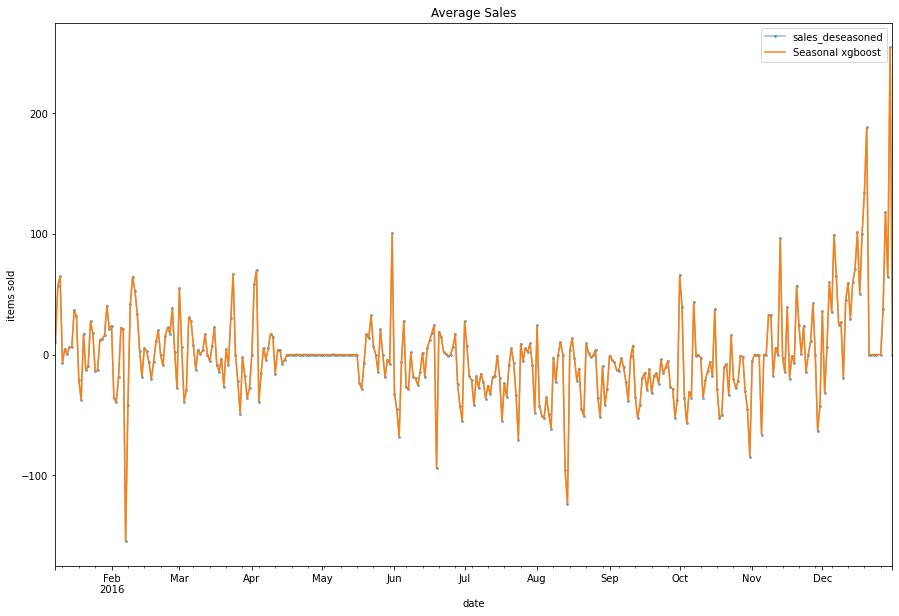

In [108]:
ax = y_deseason.plot( alpha=0.5, title="Average Sales", ylabel="items sold",marker="o",markersize=2)
ax = y2_des_pred.plot(ax=ax, label="Seasonal xgboost")
#ax = y_pred.plot(ax=ax, label="Seasonal")
plt.rcParams['figure.figsize'] = [15, 10]
ax.legend();

The random forest regressor is very good at overfitting data to find trends but has no forecasting power, while the linear model is the opposite. We will create a hybrid model that uses a linear model for the seasonal and holiday traits, and a random forest to fit the deseasoned residuals and "fill in the gaps" so to speak.

### 2013-2017

Repeating a few of the steps in the previous section, however now we span multiple years so we will include the year as an additional seasonal feature.

In [178]:
average_sales_all = (store_sales.groupby('date').mean().squeeze())
y = average_sales_all.copy()
holidays = (holidays_events.query("locale in ['National', 'Regional']")
            .loc[:'2017-08-16',['description']]
            .assign(description=lambda x: x.description.cat.remove_unused_categories()))

In [179]:
fourier = CalendarFourier("M",4)
fourier_year = CalendarFourier("Y",2)
dp = DeterministicProcess(index = y.index,
                          constant=True,
                          order=1,
                          seasonal=True,
                          additional_terms=[fourier,fourier_year],
                          drop=True,
                         )
X = dp.in_sample()

In [180]:
X_holidays = pd.DataFrame(
       ohe.fit_transform(holidays),
       index=holidays.index,
       columns=holidays.description.unique(),
)
X2 = X.join(X_holidays, on='date').fillna(0.0)
X2 = X2[~X2.index.duplicated(keep='first')]

In [181]:
median_7 = y.rolling(7).median()
median_7.name = "median_7"
std_7 = y.rolling(7).std()
std_7.name = 'std_7'
oil = pd.read_csv("oil.csv",parse_dates=['date'])
oil = oil.set_index('date').to_period('D')
oil_median_7 = oil.rolling(7).median()
oil_median_7.name='oil'
#X_lags = make_lags(y_deseason,lags=1)
#X_lags.name="lag_1"


In [182]:
X2 = X2.join(median_7, on='date').fillna(0.0)
X2 = X2.join(std_7, on='date').fillna(0.0)
X2 = X2.join(oil_median_7,on='date').fillna(0.0)
#X4 = X3.join(X_lags,on='date').fillna(0.0)

In [183]:
model = LinearRegression()
model.fit(X2,y)
y_deseason = y - model.predict(X2)

In [184]:
X_lags = make_lags(y_deseason,lags=7)

In [185]:
y = pd.DataFrame(y,index=y.index,columns=['sales'])
y_train,y_valid =  y[:"2017-07-01"], y["2017-07-02":]
X_train, X_valid =  X2[:"2017-07-01"], X2["2017-07-02":]
X4_train, X4_valid =  X_lags[:"2017-07-01"], X_lags["2017-07-02":]
model = Boostedhybrid(model1=LinearRegression(),model2=XGBRegressor())
model.fit(X_train,X4_train,y_train)
y_train = model.predict(X_train,X4_train)
y_pred = model.predict(X_valid,X4_valid)

y_pred = y_pred.clip(0.0)

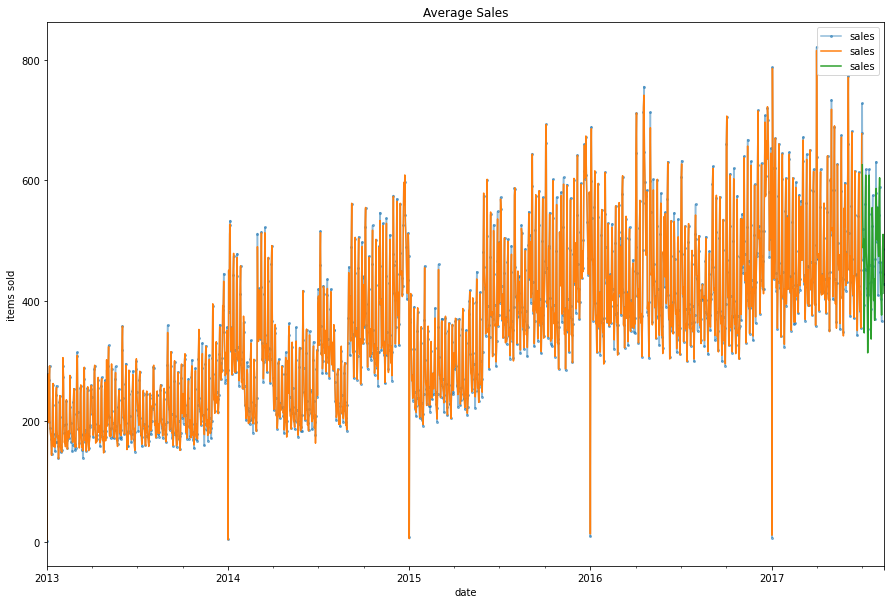

In [187]:
ax = y.plot( alpha=0.5, title="Average Sales", ylabel="items sold",marker="o",markersize=2)
ax = y_train.plot(ax=ax, label="Seasonal train")
ax = y_pred.plot(ax=ax, label="Seasonal predict")
ax.legend()
plt.rcParams['figure.figsize'] = [15, 10]
ax.legend();

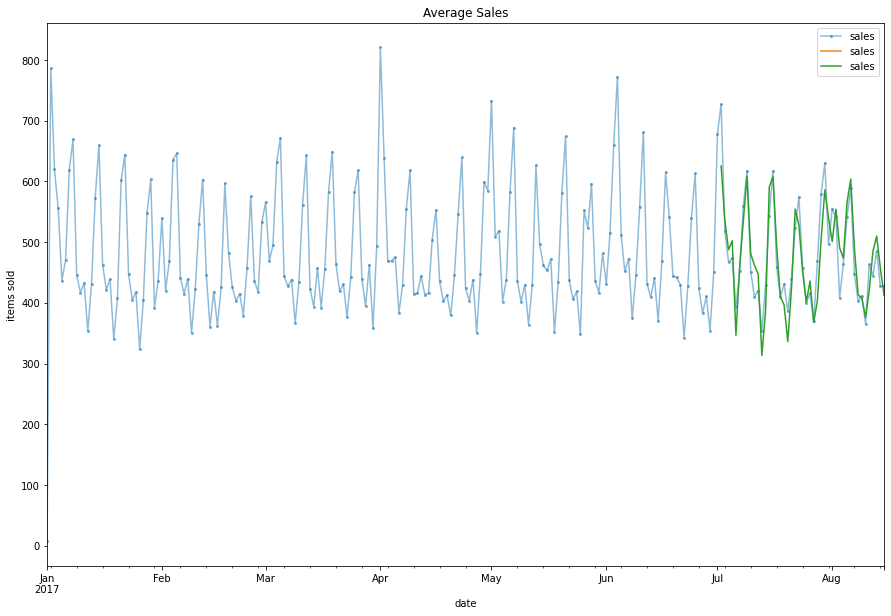

In [176]:
ax = y["2017-01-01":].plot( alpha=0.5, title="Average Sales", ylabel="items sold",marker="o",markersize=2)
ax = y_train["2017-01-01":].plot(ax=ax, label="Seasonal train")
ax = y_pred.plot(ax=ax, label="Seasonal predict")
ax.legend()
plt.rcParams['figure.figsize'] = [15, 10]
ax.legend();

## Grocery I

In [202]:
store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc[:,['sales', 'onpromotion']]
)

In [203]:
grocery_sales = family_sales.loc(axis=1)[:,"GROCERY I"]
y = grocery_sales.loc[:,'sales'].squeeze()
model = LinearRegression(fit_intercept=False)
model.fit(X2,y)
y_deseason = y - model.predict(X2)
y_deseason.name = 'sales_deseasoned'

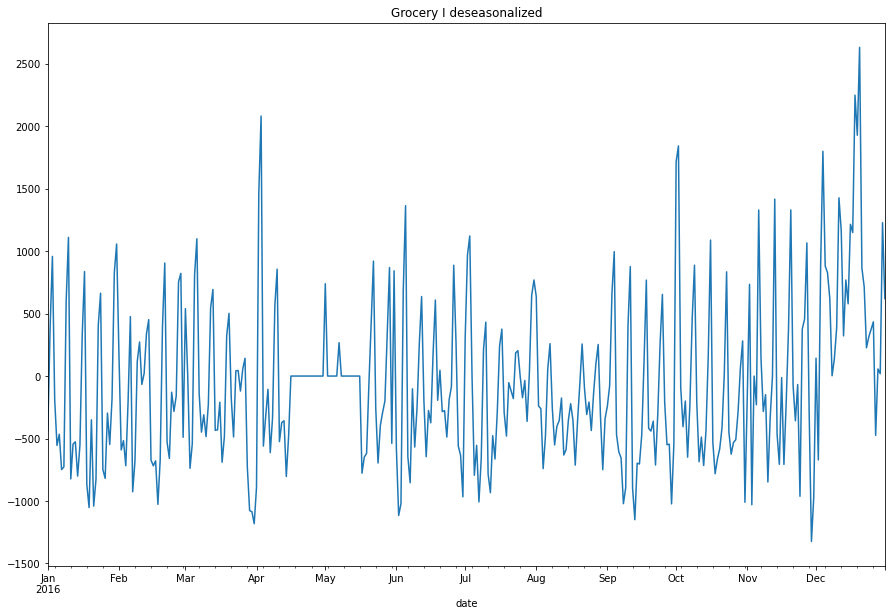

In [140]:
ax = y_deseason.loc['2016'].plot()
ax.set_title("Grocery I deseasonalized");

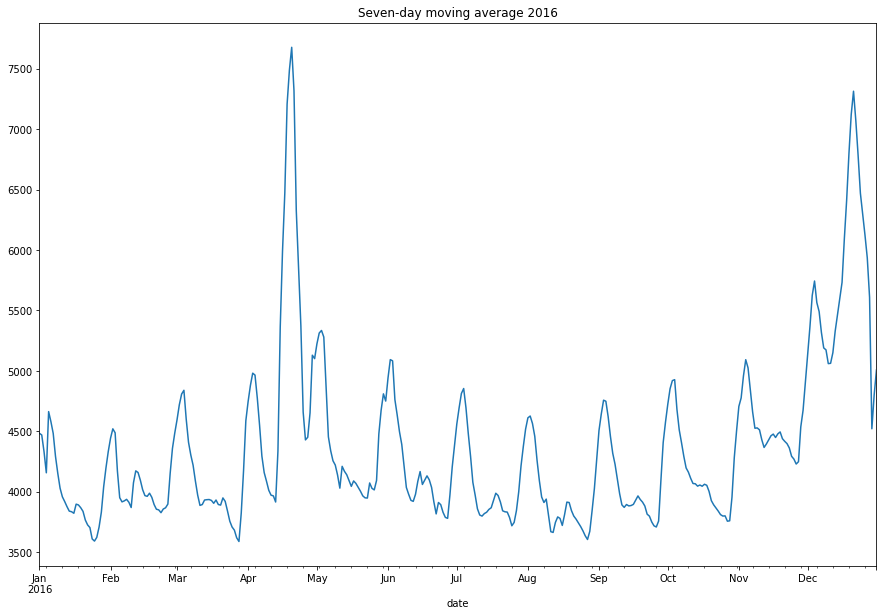

In [141]:
y_ma = y.rolling(7,center=True).mean()
ax = y_ma.loc['2016'].plot()
ax.set_title("Seven-day moving average 2016");

/Users/christopherjohnson/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


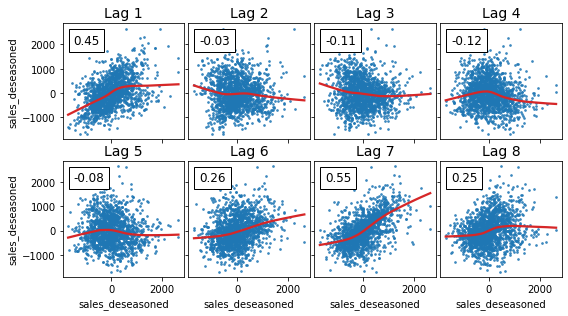

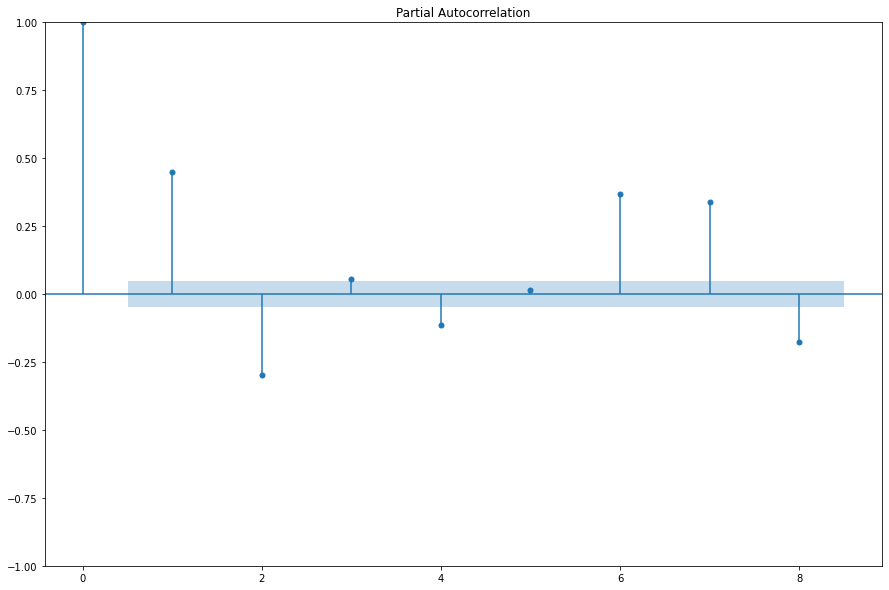

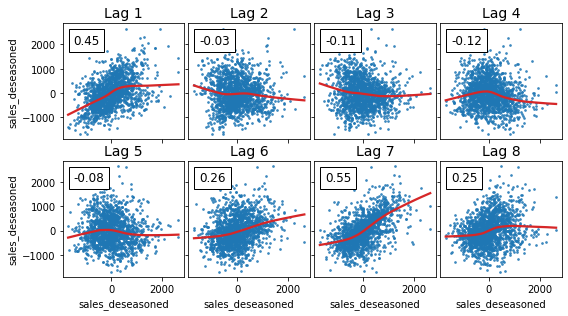

In [142]:
plot_pacf(y_deseason, lags=8)
plot_lags(y_deseason, lags=8, nrows=2)

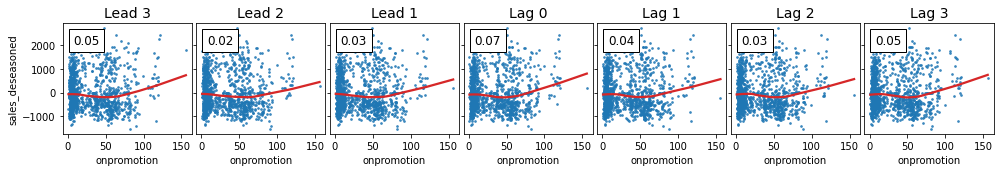

In [387]:
onpromotion = grocery_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1);

In [204]:
fourier = CalendarFourier("M",4)
fourier_year = CalendarFourier("Y",2)
dp = DeterministicProcess(index = y.index,
                          constant=True,
                          order=1,
                          seasonal=True,
                          additional_terms=[fourier,fourier_year],
                          drop=True,
                         )
X = dp.in_sample()


X_lags = make_lags(y_deseason,lags=7).dropna(0.0)

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_46242/1934207649.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  X_lags = make_lags(y_deseason,lags=7).dropna(0.0)


In [205]:
median_7 = y.rolling(7).median()
median_7.name = "median_7"
std_7 = y.rolling(7).std()
std_7.name = 'std_7'
X2 = X.join(X_holidays, on='date').fillna(0.0)
X2 = X2[~X2.index.duplicated(keep='first')]
X2 = X2.join(median_7, on='date').fillna(0.0)
X2 = X2.join(std_7, on='date').fillna(0.0)
X2 = X2.join(oil_median_7,on='date').fillna(0.0)

In [206]:
y = pd.DataFrame(y,index=y.index)

y_train,y_valid =  y["2013-01-08":"2017-07-01"], y["2017-07-02":]
X_train, X_valid =  X2["2013-01-08":"2017-07-01"], X2["2017-07-02":]
X4_train, X4_valid =  X_lags[:"2017-07-01"], X_lags["2017-07-02":]
#X4_train, X4_valid = X_train,X_valid
model = Boostedhybrid(model1=LinearRegression(),model2=XGBRegressor())
#model = LinearRegression()
model.fit(X_train,X4_train,y_train)
y_train = model.predict(X_train,X4_train)
y_pred = model.predict(X_valid,X4_valid)

y_pred = y_pred.clip(0.0)

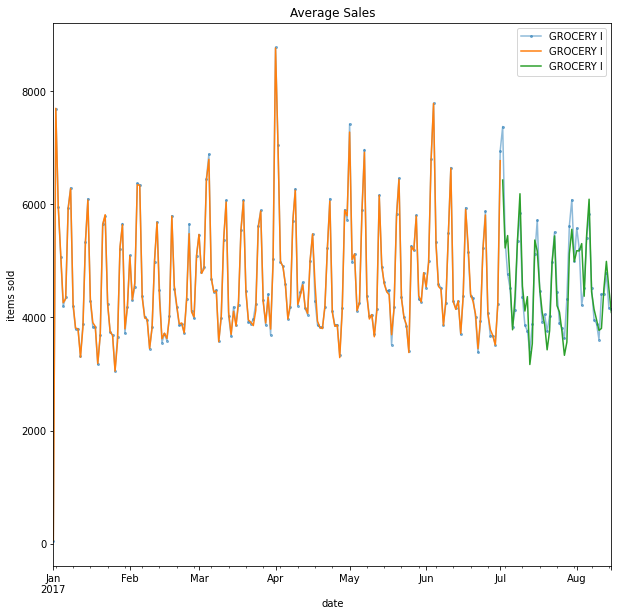

In [208]:
ax = y["2017-01-01":].plot( alpha=0.5, title="Average Sales", ylabel="items sold",marker="o",markersize=2)
ax = y_train["2017-01-01":].plot(ax=ax, label="Seasonal train")
ax = y_pred.plot(ax=ax, label="Seasonal predict")
ax.legend()
plt.rcParams['figure.figsize'] = [15, 10]
ax.legend()

## The rest of the family

In [209]:
def fit_multi_families(family_list):
    # creates seasonal features
    
    y_all = family_sales.loc[:,'sales']
    
    fourier = CalendarFourier("M",4)
    fourier_year = CalendarFourier("Y",2)
    dp = DeterministicProcess(index = y_all.index,
                          constant=True,
                          order=1,
                          seasonal=True,
                          additional_terms=[fourier,fourier_year],
                          drop=True,
                         )
    X = dp.in_sample()
    
    # join holidays 
    X2 = X.join(X_holidays, on='date').fillna(0.0)
    X2 = X2[~X2.index.duplicated(keep='first')]
    
    
    oil = pd.read_csv("oil.csv",parse_dates=['date'])
    oil = oil.set_index('date').to_period('D')
    oil.name = 'oil'
    
    X2 = X2.join(oil_median_7,on='date').fillna(0.0)
    
    # create deseasoned characteristics for lags 

    
    model = LinearRegression(fit_intercept=False)
    model.fit(X2,y_all)
    y_deseason = y_all - model.predict(X2)
    y_deseason.name = 'sales_deseasoned'
    y_list, y_train_list, y_pred_list = [],[],[]
    for fam in family_list:
        X_lags = make_lags(y_deseason[fam],lags=7).dropna(0.0)
        y = y_all[fam]
        y,X_lags = y.align(X_lags)
        
        # add statistical features                               
        median_7 = y.rolling(7).median()
        median_7.name = "median_7"
        std_7 = y.rolling(7).std()
        std_7.name = 'std_7'
        X_new = X2
        X_new = X_new.join(median_7, on='date').fillna(0.0)
        X_new = X_new.join(std_7, on='date').fillna(0.0)
        
        y = pd.DataFrame(y,index=y.index,columns=[fam])
        
        y_train,y_valid =  y["2013-01-08":"2017-07-01"], y["2017-07-02":]
        X_train, X_valid =  X_new["2013-01-08":"2017-07-01"], X_new["2017-07-02":]
        X4_train, X4_valid =  X_lags["2013-01-08":"2017-07-01"], X_lags["2017-07-02":]
        #X4_train, X4_valid = X_train,X_valid
        model = Boostedhybrid(model1=LinearRegression(),model2=XGBRegressor())
        #model = LinearRegression()
        model.fit(X_train,X4_train,y_train)
        y_train = model.predict(X_train,X4_train)
        y_pred = model.predict(X_valid,X4_valid)
        y_list.append(y);y_train_list.append(y_train);y_pred_list.append(y_pred.clip(0.0));

    return y_list, y_train_list, y_pred_list
        



In [211]:
family_list = cols_to_show
y, y_train, y_pred= fit_multi_families(family_list);

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_46242/2755041986.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  X_lags = make_lags(y_deseason[fam],lags=7).dropna(0.0)
/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_46242/2755041986.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  X_lags = make_lags(y_deseason[fam],lags=7).dropna(0.0)
/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_46242/2755041986.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  X_lags = make_lags(y_deseason[fam],lags=7).dropna(0.0)
/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_46242/2755041986.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  X_lags = make_lags(y_deseason[fam],lags=7).dropna(0.0)
/var/folders/zh/dvg4994d0_v8dpj_6tb0

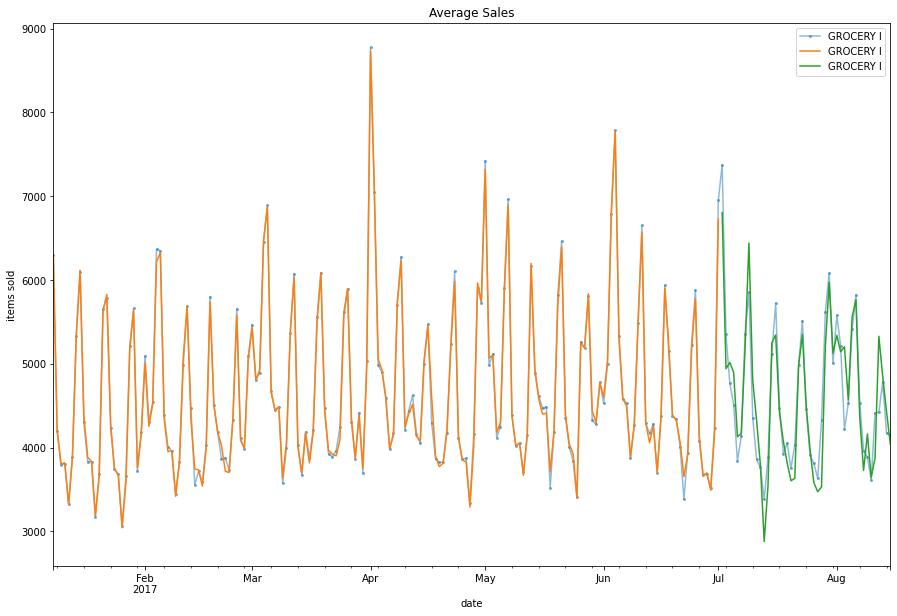

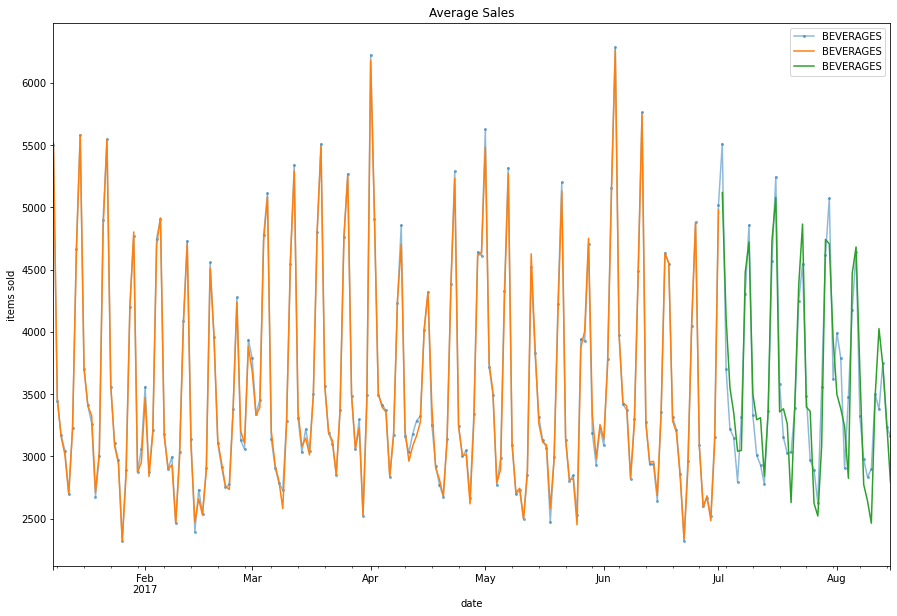

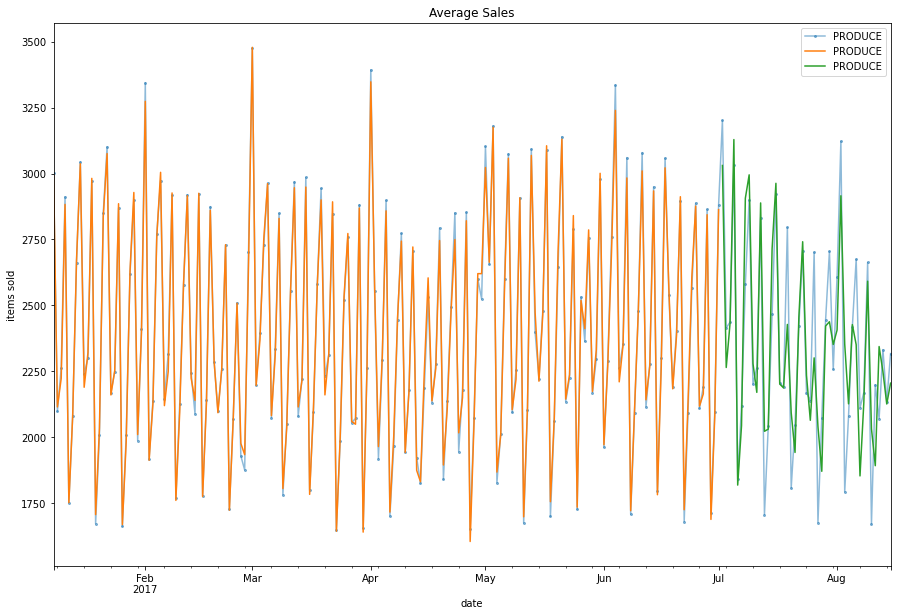

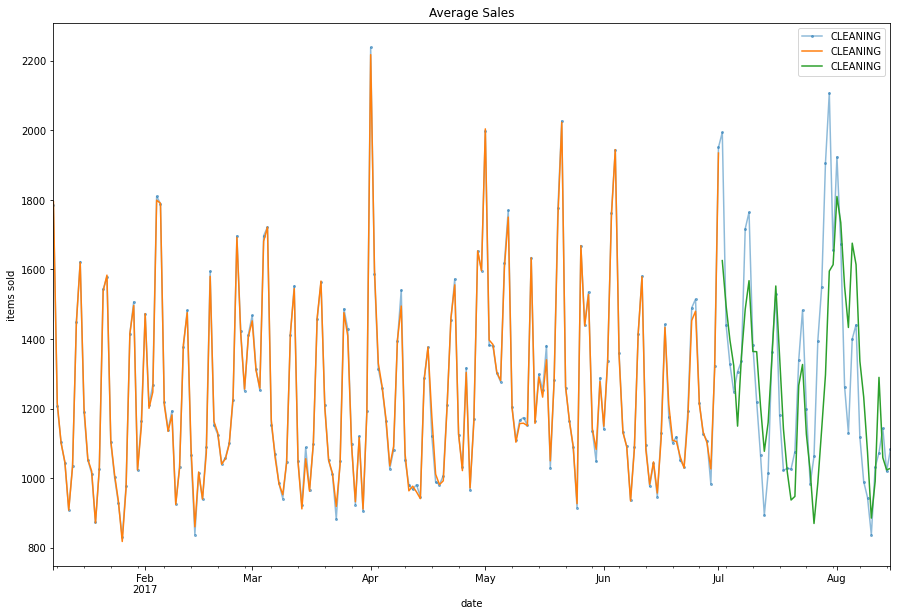

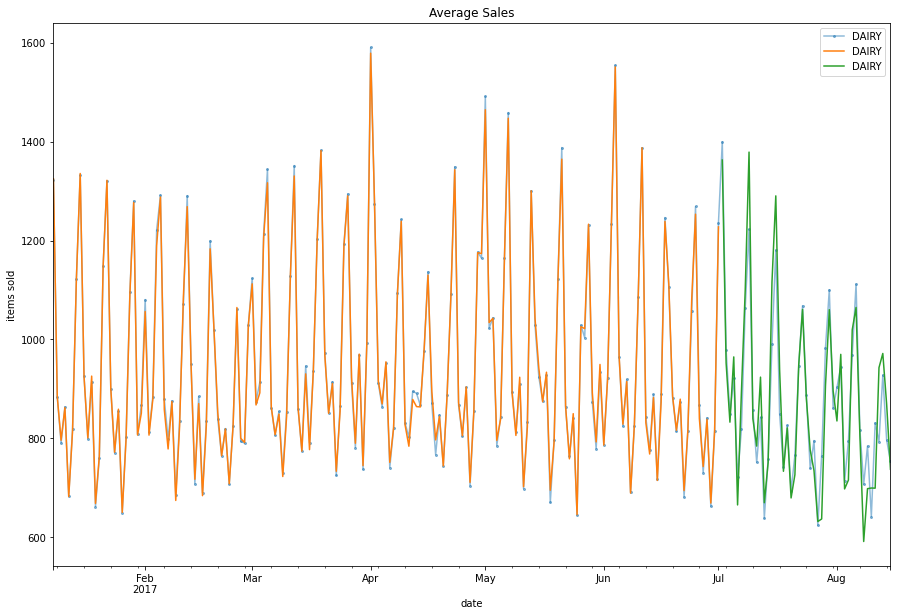

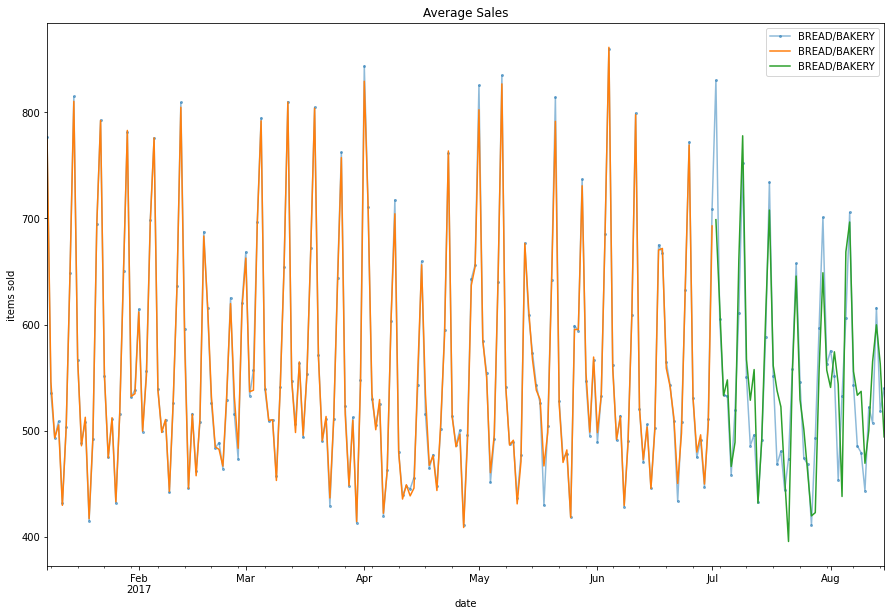

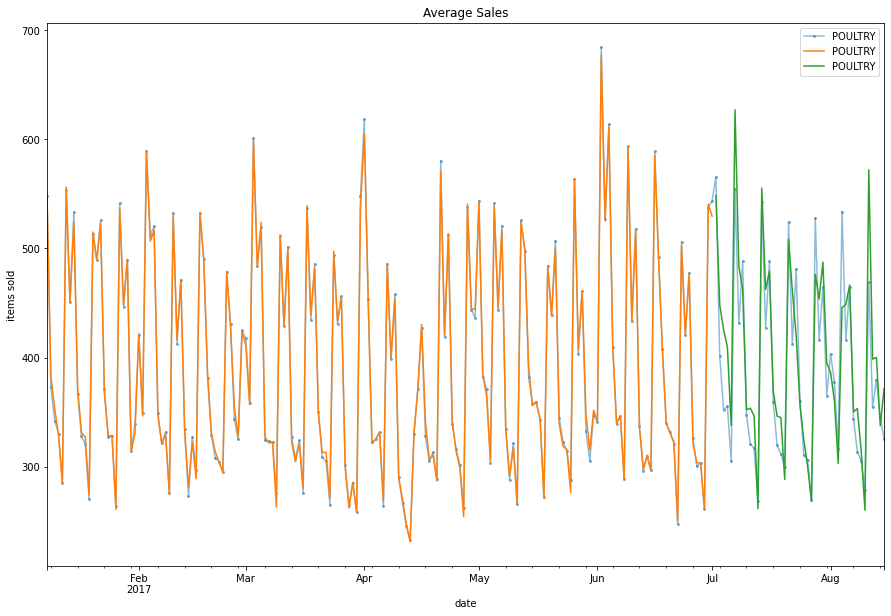

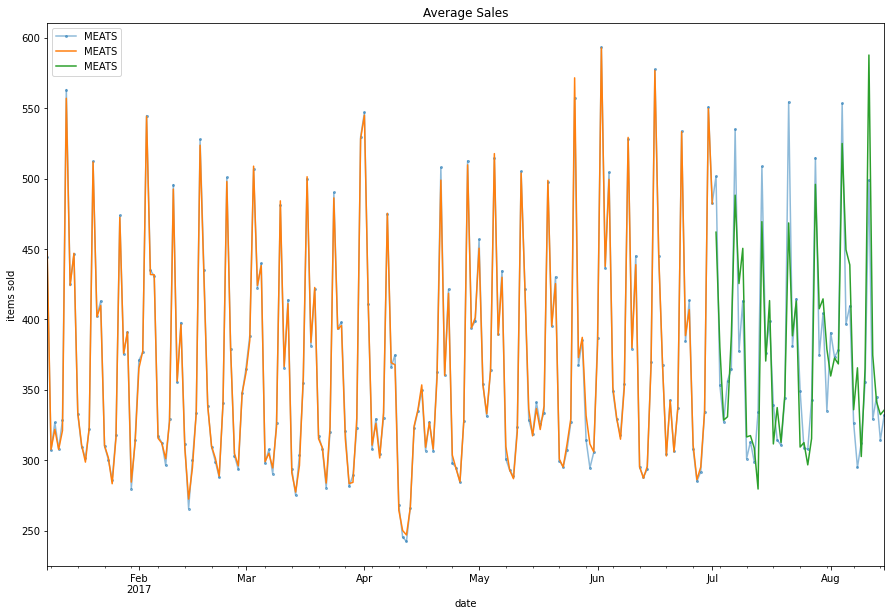

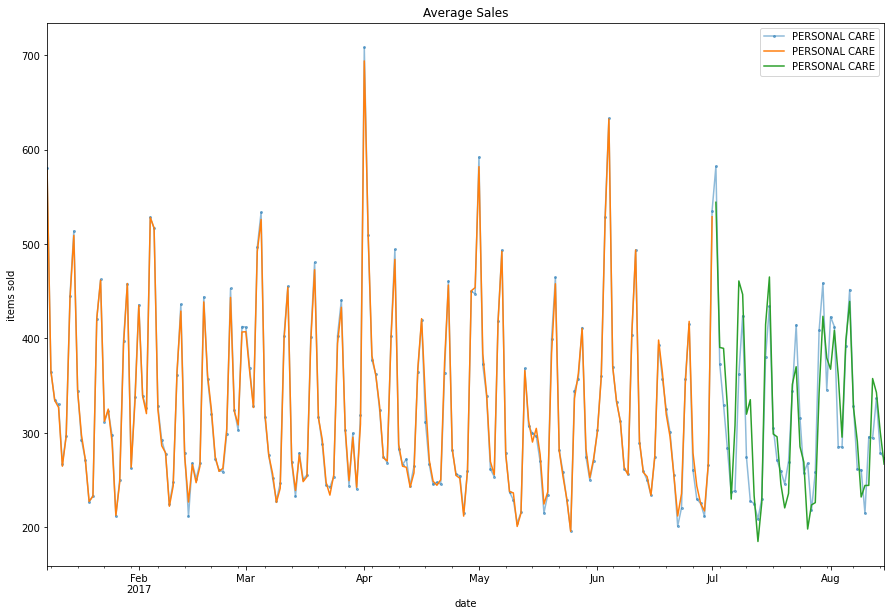

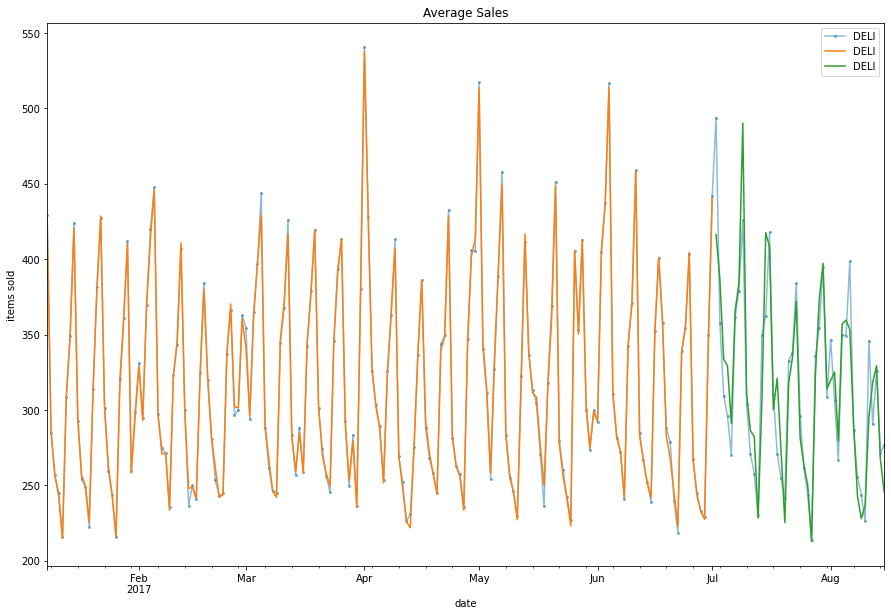

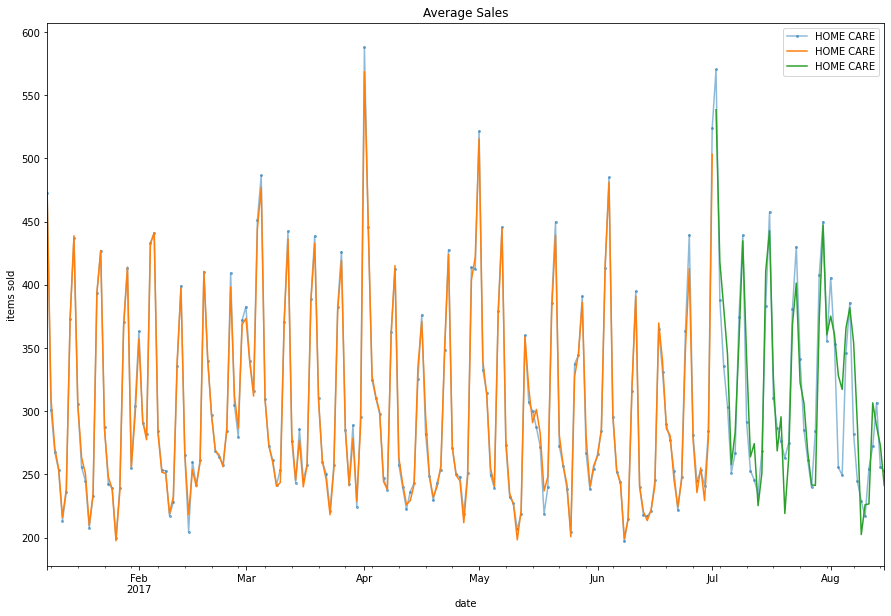

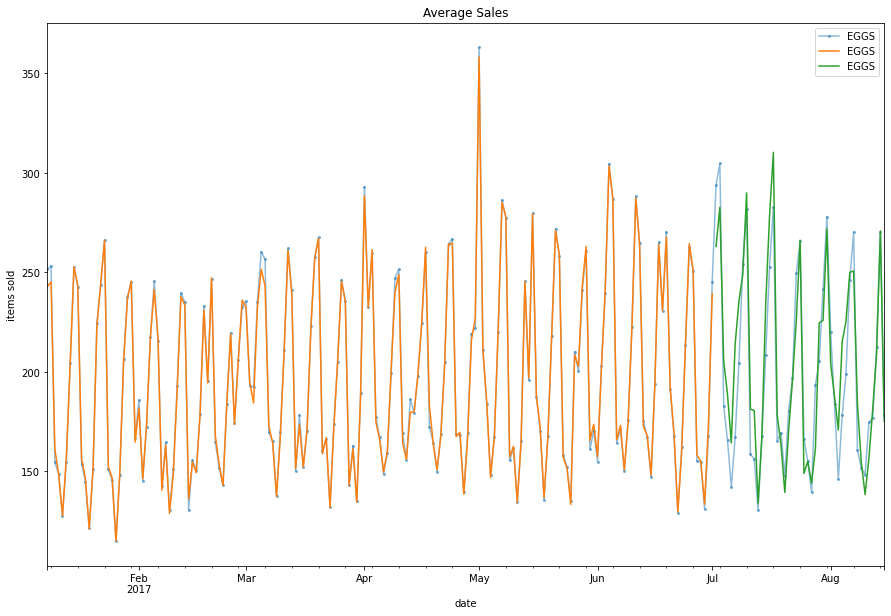

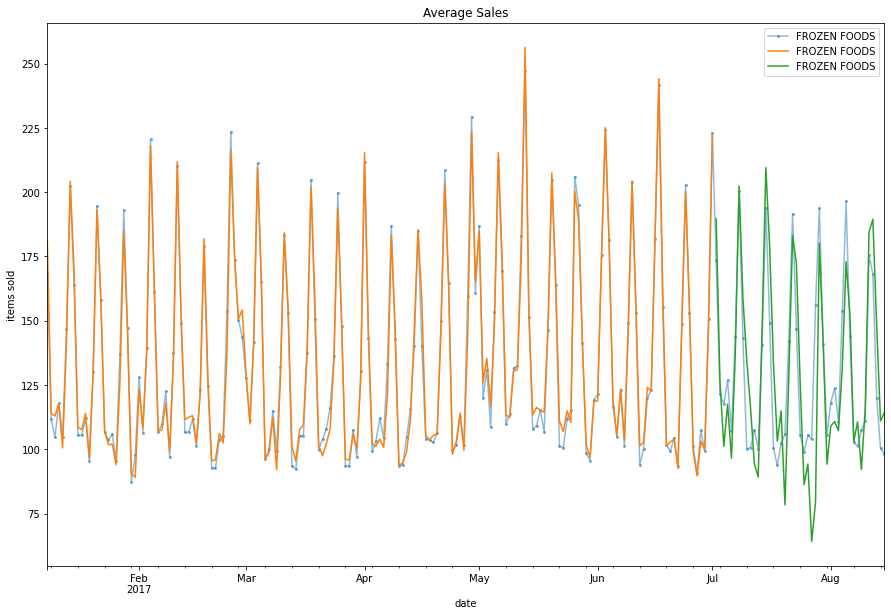

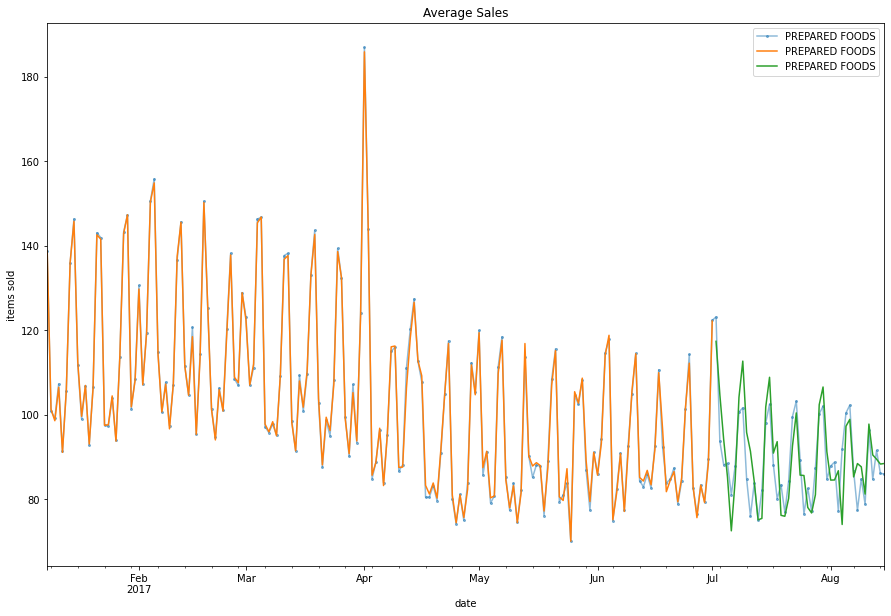

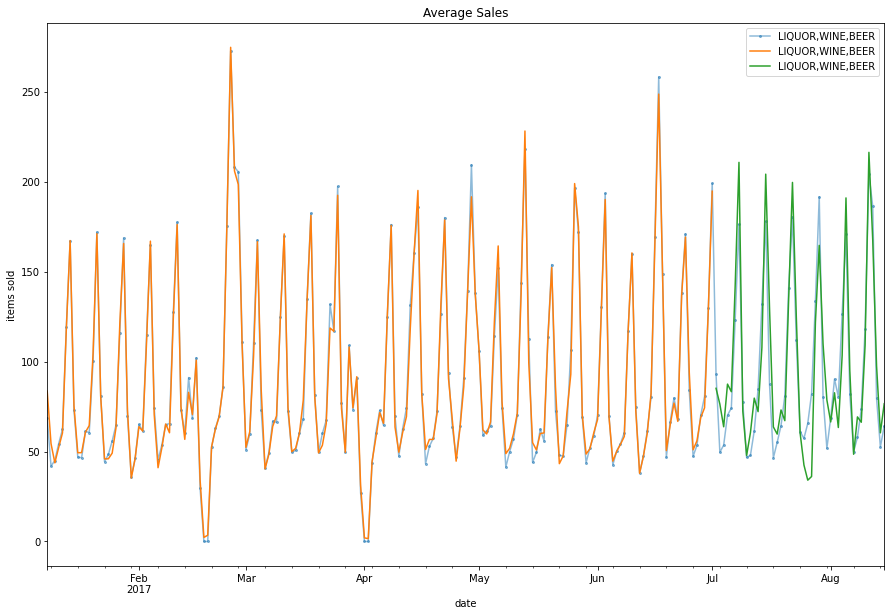

In [212]:
for i in range(len(y)):
    ax = y[i]["2017-01-08":].plot( alpha=0.5, title="Average Sales", ylabel="items sold",marker="o",markersize=2)
    ax = y_train[i]["2017-01-08":].plot(ax=ax, label="Seasonal train")
    ax = y_pred[i].plot(ax=ax, label="Seasonal predict")
    ax.legend()
    plt.rcParams['figure.figsize'] = [15, 10]
    ax.legend()